# About python imports

No imports are specified as in previous homeworks, please insert the necessary python code yourself.

-----
# Exercise 1 (3 points)
Write a program implementing Rayleigh quotient iteration for computing an eigenvalue and corresponding eigenvector of a matrix. Test your program on the matrix 
$$
  A = \begin{bmatrix} 6 & 2 & 1 \\ 2& 3 & 1 \\ 1 & 1 & 1  \end{bmatrix}
$$
using a random starting vector. Let the program create output that shows the convergence behavior.

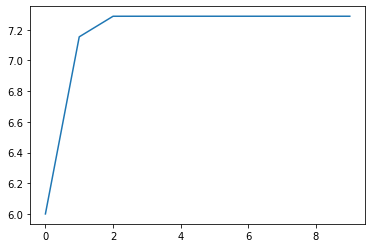

In [3]:
# python code here
import numpy as np
import matplotlib.pyplot as plt

def rayleigh(A, x, iterations):
    x_ks = [x]
    sigma_ks = []
    for i in range(iterations):
        sigma_k = x_ks[-1].T.dot(A).dot(x_ks[-1])/x_ks[-1].T.dot(x_ks[-1])
        sigma_ks.append(sigma_k)
        
        y_k = np.linalg.solve(A - sigma_k*np.identity(len(A)), x_ks[-1])
        x_ks.append(y_k/np.linalg.norm(y_k))
    return x_ks, sigma_ks
        
x = np.ones(3)
A = np.array(((6,2,1),(2,3,1),(1,1,1)))
x_k, sigma_k = rayleigh(A,x,10)
plt.plot(sigma_k)
plt.show()

# Automatic differentiation using JAX

In applications of rootfinding, computing the derivative is often a problematic step. For example, the function for which zeros are sought might be given by a complicated computer program. 

Automatic differentiation is a set of techniques to evaluate the derivative of a function specified by a computer program. See the [wikipedia page](https://en.wikipedia.org/wiki/Automatic_differentiation) on this topic.

[JAX](https://github.com/google/jax) is a software package that implements automatic differentiation as well as other functionality. [The documentation is here](https://jax.readthedocs.io/en/latest/). The idea of this exercise is to use JAX for obtaining derivative functions.

To use JAX, there are two options:
- install JAX. The installation of JAX is described on the Github page, see https://github.com/google/jax#installation.  **It appears that installation under Windows is not supported. According to the internet, one may use the Windows Subsystem for Linux, but I haven't tested this.**
- run your python notebook on the google colab environment. The google colab environment is at https://colab.research.google.com. In the google colab environment, the JAX package is available. 

There is some material online about JAX, see for example
https://medium.com/swlh/solving-optimization-problems-with-jax-98376508bd4f
(LATEX-pdf version here
https://github.com/mazy1998/Solving-Optimization-Problems-with-JAX/blob/master/Opitimization_with_jax.pdf)
or 
https://www.kaggle.com/aakashnain/tf-jax-tutorials-part1.

The result is that for many functions, the derivative can be automatically computed. We will show this for a vector valued function $\mathbb{R}^2 \to \mathbb{R}^2$. 

The first step is to import some functions from the package JAX. Notice that JAX has its own version of numpy. Here we import it as `jnp`.

In [4]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev

# depending on the application, more imports are needed

JAX implements forward and reverse mode automatic differentiation. The commands are `jacfwd` and `jacrev` (jac stands for Jacobian). The [wikipedia page on automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) briefly introduces forward and reverse mode automatic differentiation. Here we just mention that forward accumulation is more efficient than reverse accumulation for functions $f : \mathbb{R}^n \to \mathbb{R}^m$ with $m \gg n$ as only $n$ sweeps are necessary, compared to $m$ sweeps for reverse accumulation and that reverse accumulation is more efficient than forward accumulation for functions $f : \mathbb{R}^n \to \mathbb{R}^m$ with $m \ll n$ as only $n$ sweeps are necessary.

In the following cell a simple function is defined and differentiated. Note that JAX has its own array type, `jax.numpy.array` (because of the line `import jax.numpy as jnp` we write this as `jnp.array`), that output is in 32 bits floating point format in a different array type `DeviceArray` (JAX has a preference for the 32 bits floating point format and you are allowed to use it in this exercise). 

In [5]:
def circle(x): return x[0]**2 + x[1]**2
J = jacfwd(circle)
J(jnp.array([1.0 ,2.0]))

DeviceArray([2., 4.], dtype=float32)

It is allowed to take derivatives of derivatives, so that a second derivative matrix can be obtained.

In [6]:
def hessian(f): return jacfwd(jacrev(f))
H = hessian(circle)
myMatrix = H(jnp. array ([1.0 ,2.0]) )
print(myMatrix)

[[2. 0.]
 [0. 2.]]


Although this is not the standard `numpy.ndarray` format, it appears however that this format can be used in linear algebra operations such as solve.

In [7]:
myVector = jnp.array([0.5, 2.0])

import scipy.linalg as la
la.solve(myMatrix, myVector)

array([0.25, 1.  ], dtype=float32)

It is easy to define vector valued functions, by returning an `jax.numpy.array` object. 

When using functions such as $\sin$ and $\cos$ and $\exp$ one must be careful. One must use the functions `jax.numpy.sin`, `jax.numpy.cos`, etc. (and not `math.sin` etc.). We define a test function $f(x_1,x_2) = [x_1 \exp(x_2), x_1+x_2]$ using $\exp$ and show that it can be differentiated. Note that the derivative matrix is $\begin{bmatrix} \exp(x_2) & x_1 \exp(x_2) \\ 1 & 1 \end{bmatrix}$.

In [8]:
def f(x):
    return jnp.array([x[0] * jnp.exp(x[1]), x[0] + x[1]])

print("values:")
print(f(jnp.array([2.0,1.0])))

Df = jacfwd(f)
print("jacobian matrix:")
print(Df(jnp.array([2.0,1.0])))


values:
[5.4365635 3.       ]
jacobian matrix:
[[2.7182817 5.4365635]
 [1.        1.       ]]


# Exercise 2 (rootfinding with automatic differentiation, 3 points)

## (a)
Create a Python function to apply Newton's method in multiple dimensions. Create a stopping criterion, such that your method automatically stops when one of the following conditions is satisfied: (i) the size of the function is below a specified tolerance; (ii) the difference in two subsequent iterates $\mathbf{x}_k$ is below a specified tolerance; (iii) the number of iterations reaches a specified limit.

Size of function is below tolerance.
x_k = [-6.002665e-08  1.000000e+00]


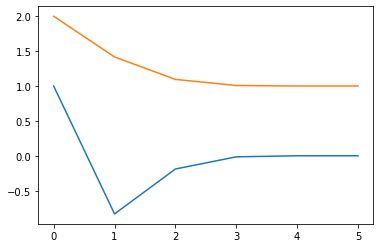

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return jnp.array([x[0] + 2 * x[1] - 2, x[0]**2 + 4 * x[1]**2 - 4])

def Newton(fun, x, iterations, *args):
  x_ks = [x]
  Df = jacfwd(fun)
  for i in range(iterations):
    x_ks.append(x_ks[-1] + la.solve(Df(x_ks[-1], *args), -fun(x_ks[-1], *args)))
    
    # Check the length of f(x_{k-1})
    if la.norm(fun(x_ks[-1], *args)) < 0.000001:
      print("Size of function is below tolerance.")
      break

    # How to calculate difference between vectors?
    # Checks the difference in all positions seperately
    x_difference = np.abs(x_ks[-1] - x_ks[-2])
    if [diff for diff in x_difference if diff < 0.000001]:
      print("The difference in two subsequent iterations is below tolerance.")
      break
  
  if len(x_ks) == iterations + 1:
    print("The number of iterations was reached.")

  print('x_k =', x_ks[-1])
  return x_ks

x = jnp.array([1.,2.])
plt.plot(Newton(f, x, 10))
plt.show()

## (b)
Solve Computer Exercise 5.19 using Newton's method and automatic differentiation. (N.B. Do not choose the starting point equal to a solution.)

Bacterial density is zero
Size of function is below tolerance.
x_k = [ 6.82121e-13 -1.00000e+00]


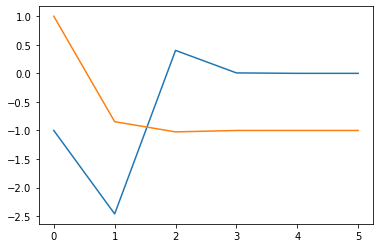

Bacterial density is not zero
The difference in two subsequent iterations is below tolerance.
x_k = [-19.999998     0.25000003]


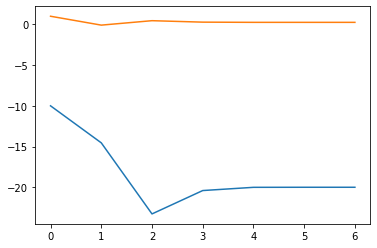

In [10]:
# your answer here
def bio_fun(x, gamma, delta):
  return jnp.array([gamma * x[0] * x[1] - x[0] * (1 + x[1]), 
                    -x[0] * x[1] + (delta - gamma) * (1 + x[1])])

gamma = 5
delta = 1
# TODO: wat bedoelen ze precies met nonzero bacterial density? Dat newton uitkomt op x = 0?
print("Bacterial density is zero")
x = jnp.array([-1.,1.])
plt.plot(Newton(bio_fun, x, 10, gamma, delta))
plt.show()

print("Bacterial density is not zero")
x = jnp.array([-10.,1.])
plt.plot(Newton(bio_fun, x, 10, gamma, delta))
plt.show()

Explanation using $\LaTeX$ here

TODO

# Exercise 3 (3 points)

## (a)

Consider the system 
$$\begin{aligned}(x_1+3)(x_2^3-7) + 18 = {}& 0 \\
\sin(x_2 e^{x_1} -1) = {}& 0 .
\end{aligned}$$
Solve this system using Newton's method with starting 
point $\mathbf{x}_0 = [ 0.5 \;\; 1.4 ] ^T$.


The difference in two subsequent iterations is below tolerance.
x_k = [-1.0876215e-07  1.0000001e+00]


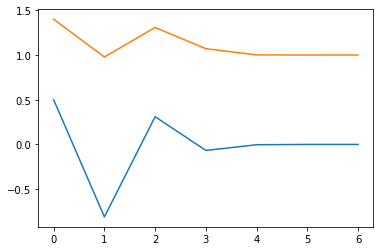

In [11]:
# your answer here
def fun3(x):
  return jnp.array([(x[0] + 3)*(x[1]**3 - 7) + 18, jnp.sin(x[1]*jnp.exp(x[0]) - 1)])

x = jnp.array([0.5, 1.4])
newton = Newton(fun3, x, 10)
plt.plot(newton)
plt.show()

## (b)
Write a program based on Broyden's method to solve the same system with the same starting point.

In [21]:
def Broyden(fun,x0,iterations):
  b0 = jacfwd(fun)
  x_ks = [x0]
  y_ks = [fun(x0)]
  B_ks = [b0(x_ks[-1])]
  for k in range(iterations):
    sk = la.solve(B_ks[-1], -fun(x_ks[-1]))
    x_ks.append(x_ks[-1] + sk)
    y_ks.append(fun(x_ks[-1]) -fun(x_ks[-2]))
    B_ks.append(B_ks[-1] + (((y_ks[-1] - B_ks[-1].dot(sk)).dot(sk.T)) / (sk.T.dot(sk))))

    # Check the length of f(x_{k-1}) 
    if la.norm(fun(x_ks[-1])) < 0.000001:
      print("Size of function is below tolerance.")
      break

    # How to calculate difference between vectors?
    # Checks the difference in all positions seperately
    x_difference = np.abs(x_ks[-1] - x_ks[-2])
    if [diff for diff in x_difference if diff < 0.000001]:
      print("The difference in two subsequent iterations is below tolerance.")
      break
  
  if len(x_ks) == iterations + 1:
    print("The number of iterations was reached.")

  print('x_k =', x_ks[-1])
  return x_ks

## (c)
Compare the convergence rates of the two methods by computing the error at each iteration and appropriately analysing these errors, given that the exact solution is $\mathbf{x}^* = [ 0 \;\; 1 ]^T$.

The number of iterations was reached.
x_k = [-1.8721012 -2.009959 ]


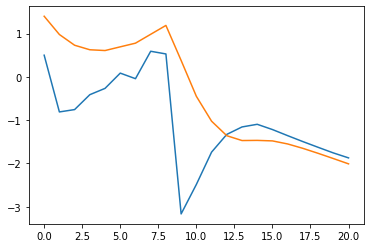

[[5.00000000e-01 3.99999976e-01]
 [8.10472131e-01 2.18353271e-02]
 [3.10097575e-01 3.07959795e-01]
 [6.70029819e-02 7.06260204e-02]
 [3.33749503e-03 1.13677979e-03]
 [1.09127723e-06 7.15255737e-07]
 [1.08762151e-07 1.19209290e-07]]


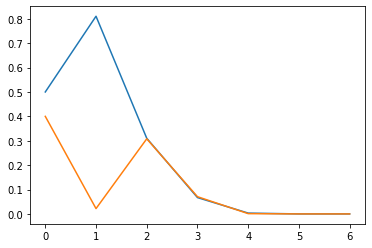

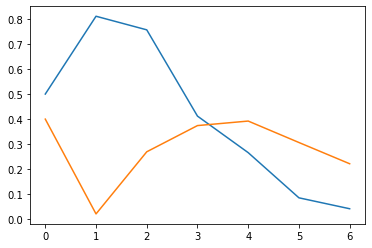

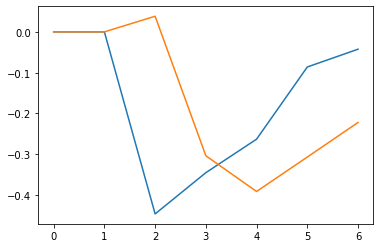

In [24]:
x = jnp.array([.5,1.4])
broyden = Broyden(fun3,x,20) 
plt.plot(broyden)
plt.show()

difference_newton = np.zeros((len(newton), 2))
difference_broyden = np.zeros((len(newton), 2))
x_star = [0,1]
for i in range(len(newton)):
  for j in range(len(newton[i])):
    difference_newton[i][j] = np.abs(newton[i][j] - x_star[j])
    difference_broyden[i][j] = np.abs(broyden[i][j] - x_star[j])
print(difference_newton)
plt.plot(difference_newton)
plt.show()
plt.plot(difference_broyden)
plt.show()
plt.plot(difference_newton - difference_broyden)
# plt.yscale("symlog")
plt.show()

Explanation using $\LaTeX$ here